# Intercative development
This notebook is for interactive test of searched methods of segmentation

In [3]:
import cv2
from PIL import Image
from matplotlib import pyplot as plt

The block is intended for setting up image file pathes.

In [61]:
imfile = 'yolo_train_134.jpg'
solo_img_YPM = '../Plaindata/777753_ex307855_obj00573.jpg'
solo_img_NHM = '../Plaindata/ZF6499-Globigerinita-glutinata_obj00008_plane000.jpg'
furry = '../Plaindata/!ZF6590-1-Globigerinoides-sacculifer_obj00001_plane000'

Test 1: edge detection

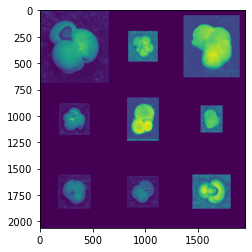

In [28]:
img_test1 = cv2.imread(imfile,0)
plt.imshow(img_test1)
plt.show()

As observed below, the result is not ideal.
the clear boundary between the image and background is bad for the segmentation. We should remove the boundary first. Some images are commpanying with clear boundaries while others are not.

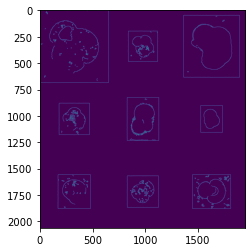

In [29]:
blurred = cv2.blur(img_test1, (3,3))
canny = cv2.Canny(blurred, 10, 90)
plt.imshow(canny)
plt.show()

Test 2: segmentation by treashold

In [39]:
ret,thresh1 = cv2.threshold(blurred,127,255,cv2.THRESH_BINARY)
ret,thresh2 = cv2.threshold(blurred,127,255,cv2.THRESH_BINARY_INV)
ret,thresh3 = cv2.threshold(blurred,127,255,cv2.THRESH_TRUNC)
ret,thresh4 = cv2.threshold(blurred,127,255,cv2.THRESH_TOZERO)
ret,thresh5 = cv2.threshold(blurred,127,255,cv2.THRESH_TOZERO_INV)

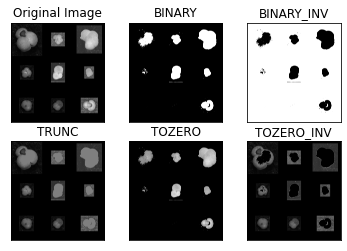

In [46]:
titles = ['Original Image','BINARY','BINARY_INV','TRUNC','TOZERO','TOZERO_INV']
images = [blurred, thresh1, thresh2, thresh3, thresh4, thresh5]
for i in range(6):
    plt.subplot(2,3,i+1),plt.imshow(images[i],'gray',vmin=0,vmax=255)
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
plt.show()

In [47]:
def easyplot(imgs, names, row, col):
    titles = names
    images = imgs
    for i in range(len(images)):
        plt.subplot(row,col,i+1),plt.imshow(images[i],'gray',vmin=0,vmax=255)
        plt.title(titles[i])
        plt.xticks([]),plt.yticks([])
    plt.show()

The result inclined that we should apply different method to the result from different collections. <br>
Thus sample two images from different collections for convient

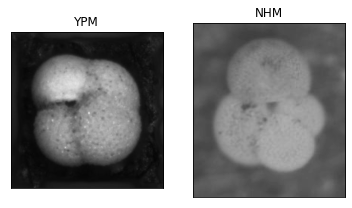

In [78]:
YPM = cv2.imread(solo_img_YPM, cv2.COLOR_BGR2BGRA)
NHM = cv2.imread(solo_img_NHM, cv2.COLOR_BGR2BGRA)

images = [YPM,NHM]
names = ['YPM','NHM']
easyplot(images,names,1,2)
# for i in range(2):
#     plt.subplot(1,2,i+1),plt.imshow(images[i],'gray',vmin=0,vmax=255)
#     plt.title(titles[i])
#     plt.xticks([]),plt.yticks([])
# plt.show()

As observed above, the YPM collection image is suitable for treahold while NHM shoud be better using segmentation

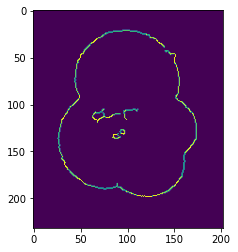

In [79]:
NHM_blurred = cv2.blur(NHM, (3,3))
NHM_canny = cv2.Canny(NHM_blurred, 10, 90)
plt.imshow(NHM_canny)
plt.show()

In [52]:
def multiple_thresold(img, lower_bound=127, upper_bound=255):
    blurred = cv2.blur(img, (3,3))
    ret,thresh1 = cv2.threshold(blurred,lower_bound,upper_bound,cv2.THRESH_BINARY)
    ret,thresh2 = cv2.threshold(blurred,lower_bound,upper_bound,cv2.THRESH_BINARY_INV)
    ret,thresh3 = cv2.threshold(blurred,lower_bound,upper_bound,cv2.THRESH_TRUNC)
    ret,thresh4 = cv2.threshold(blurred,lower_bound,upper_bound,cv2.THRESH_TOZERO)
    ret,thresh5 = cv2.threshold(blurred,lower_bound,upper_bound,cv2.THRESH_TOZERO_INV)
    imgs = [blurred, thresh1, thresh2, thresh3, thresh4, thresh5]
    titles = ['Original Image','BINARY','BINARY_INV','TRUNC','TOZERO','TOZERO_INV']
    return imgs,titles

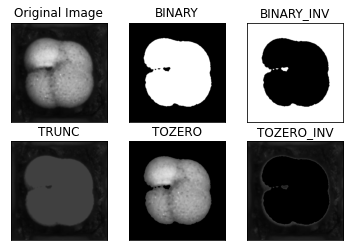

In [56]:
imgs_YPM, names_YPM = multiple_thresold(YPM,64)
easyplot(imgs_YPM, names_YPM,2,3)

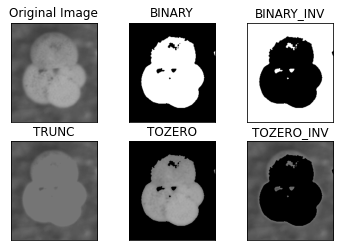

In [81]:
imgs_NHM, names_NHM = multiple_thresold(NHM,117)
easyplot(imgs_NHM, names_NHM,2,3)

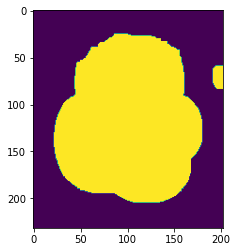

In [90]:
ret, thresh = cv2.threshold(NHM, 117, 255, 0)
rect=cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
dilation = cv2.dilate(thresh,rect,iterations = 6)
erosion = cv2.erode(dilation, rect, iterations=4)
plt.imshow(dilation)
plt.show()

In [91]:
print(dilation)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
